<h1>Exploring concepts in data cube smoothing</h1>

This noebook contains some script snippets that demonstrate a few different ways of applying smoothing operations to cube data. 

The <b>smoothing_recipe</b> notebook contains what we deem to be the "best" setup for smoothing data cubes.

<h1>Notes</h1>

- Convolution operators appropriate for smoothing can be found in: numpy, astropy, scipy. 
  - numpy
    - only 1-D
  - scipy 
    - has few multi-D smoothing options: generic, gaussian, uniform.
      - generic filters require that a 2-D or 3-D kernel array be built by the user. There are no kernel building helper functions or classes. Building a 3-D kernel for spatial/spectral cube is non-trivial.
  - astropy
    - improves over scipy
      - proper treatment of NaN values
      - a single function for 1-D, 2-D, and 3-D convolution
      - improved options for the treatment of edges
      - both direct and Fast Fourier Transform (FFT) versions
      - built-in kernels that are commonly used in astronomy. These are 1 and 2-D only, but ease the task of building a 3-D spatial/spectral kernel.
    - but these come with a price: it is up to ~100X slower than scipy (for Gaussian smoothing).

- Decoupling higher dimensionality convolution into a sequence of 1D convolutions (for symmetrical kernels) can be an option for increasing speed. It is the only solution for applying different kernel types to spatial and spectral dimensions.

<h3> Pros/cons</h3>
- astropy:
  - pros:
    - pre-defined kernel classes
    - handles NaN's
    - one convolution function call for all supported kernel types.
  - cons:
    - slow: 3-D version is way too slow (FFT is unusable)
    - 2-D + 1-D speed seems acceptable but requires looping construct by the user.
- scipy:
  - pros:
    - 3-D gaussian convolution is fastest. 
  - cons:
    - kernels must be built by user (non-trivial), except for gaussian and uniform filters.
    - does not handle NaN's
    - separate convolution function calls for each kernel type
  
<h3>In a nutshell</h3>
- cases where a Gaussian kernel is aceptable in spatial and spectral dimensions AND NaN's are not a problem: use scipy's gaussian_filter
- cases where separate kernel types are necessary for spatial and spectral dimensions, and/or NaN's are a problem: use the multi-pass 2D/1D technique illustrated below.

<h3> Glue</h3>
- scripting access as done in the examples below should be trivial in glue using the ipython console. As for a GUI widget to give access to smoothing functionality, it can be significantly complex to develop, depending on how much of those many alernatives for building kernels and running the convolution(s) it should provide access to.



In [1]:
# All imports used in this script
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.io import fits
from __future__ import print_function

from scipy.ndimage import gaussian_filter

from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel

# not using these, but import just to show what is available.
from astropy.convolution import Box2DKernel, MexicanHat2DKernel, Ring2DKernel,TrapezoidDisk2DKernel

%matplotlib inline

<h1>Test data cube</h1>

In [2]:
datacube = fits.getdata('./data/Eagle.fits')
datacube.shape

(6000, 26, 143)

<h2> A spatial plane and a spectrum in data cube</h2>

These two data cube slices contain an image plane and a spectrum. They are used as raw input for all smoothing examples found below in this notebook.

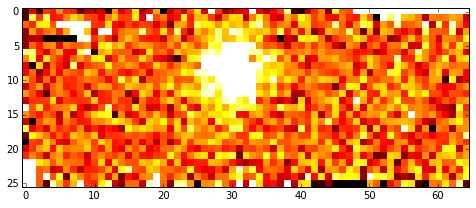

In [3]:
fig, ax = plt.subplots(figsize=(8, 10))
data = datacube[3358, :, 45:110]       # slice with spatial plane at spectral pixel #3358
ax.imshow(data, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

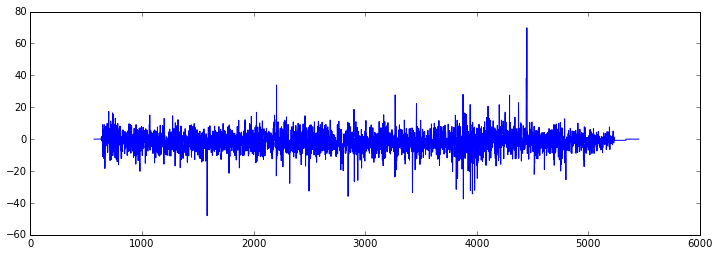

In [4]:
plt.gcf().set_size_inches(12.,4.)
spectrum = datacube[:, 8, 30]        # slice with spectrum at pixel y=8, x=30
plt.plot(spectrum)

<h1>Some simple examples of 2-D smoothing</h1>

In [5]:
gauss_kernel = Gaussian2DKernel(0.75)
tophat_kernel = Tophat2DKernel(2.5)
airy_kernel = AiryDisk2DKernel(2.5)
print('Gaussian kernel shape: ', gauss_kernel.shape)
print('Tophat kernel shape:', tophat_kernel.shape)
print('Airy disk kernel shape:', airy_kernel.shape)
data_gauss_convolved = convolve(data, gauss_kernel)
data_tophat_convolved = convolve(data, tophat_kernel)
data_airy_convolved = convolve(data, airy_kernel)

Gaussian kernel shape:  (7, 7)
Tophat kernel shape: (5, 5)
Airy disk kernel shape: (21, 21)


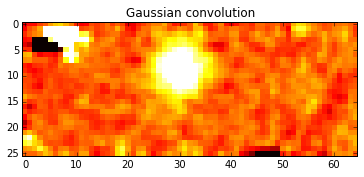

In [6]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(data_gauss_convolved, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Gaussian convolution')

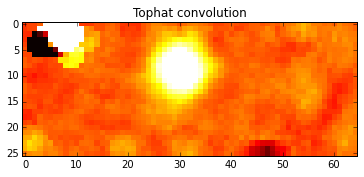

In [7]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(data_tophat_convolved, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Tophat convolution')

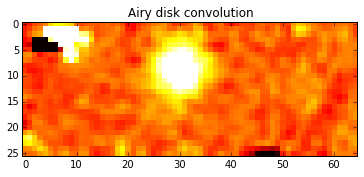

In [8]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(data_airy_convolved, cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')
ax.set_title('Airy disk convolution')

<h1>Testing different ways of doing 3-D smoothing</h1>

<h2> Single-pass 3-D operator in astropy </h2>

Astropy has a 3-D convolution function but offers no simple way of building suitable 3-D kernels for simultaneous spatial/spectroscopic smoothing. We must build a 3-D kernel by combining a 2-D with a 1-D. 

In this example we use Gaussians throughout for the ease of comparison. But we can combine different types of functions for the 2-D and 1-D parts. 

In [9]:
k1 = Gaussian1DKernel(1.)       # spectral kernel
k2 = Gaussian2DKernel(1.)       # spatial kernel
v1 = k1._array             # here we have to poke inside the instance into a private attribute (bad...)
v2 = k2._array

kernel = np.zeros(shape=[k1.shape[0],k2.shape[0],k2.shape[1]])   # 3-D kernel

for i in range(k2.shape[0]):
    for j in range(k2.shape[1]):
        kernel[:,i,j] = v2[i,j] * v1
        
print(kernel.shape)

(9, 9, 9)


Then just call the convolve function. It is *slow*!

In [10]:
start_time = time.time()

convolved = convolve(datacube, kernel)

end_time = time.time()
print(str(end_time - start_time) + " seconds.")

82.1910691261 seconds.


<h3> Result </h3>

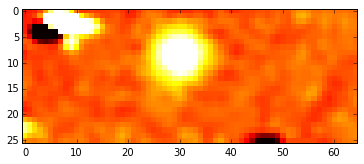

In [11]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(convolved[3358, :, 45:110], cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

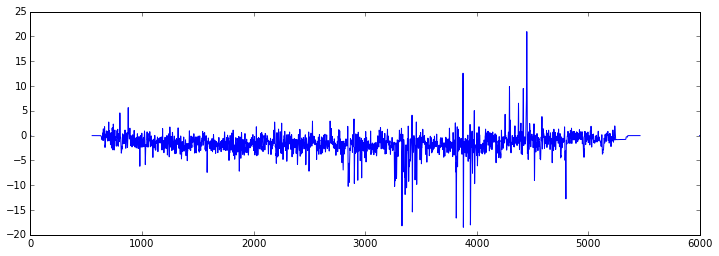

In [12]:
plt.gcf().set_size_inches(12.,4.)
spectrum = convolved[:, 8, 30]
plt.plot(spectrum)

Attempting the same 3-D convolvution as above but with 'convolve_fft' instead of 'convolve', leads to a system hang after ~10 min of furious memory swapping. Definitely not recommended except perhaps for the smallest data cubes. But then it becomes moot...

It would be interesting to evaluate convolve_fft with a data cube with dimensions given by exact powers of 2.

<h2> Single-pass 3-D operator in scipy </h2>

scipy uses a different approach from astropy. It offers no specialized kernel functions or classes, but has instead a different convolution function for each specific kernel type. It does not provide the rich variety of astropy kernel types, being limited to a 3-D Gaussian and a 3-D uniform filter. Other types should be built by the user using a similar method as above for the astropy 3-D kernel. 

The scipy convolve function does not handle NaN's in the input data cube. These should also be explicitly handled by the user.

It is *much* faster than astropy though.

In [13]:
start_time = time.time()

fcube = gaussian_filter(datacube, (1.,1.,1.)) 

end_time = time.time()
print(str(end_time - start_time) + " seconds.")

1.39837002754 seconds.


<h3> Result </h3>

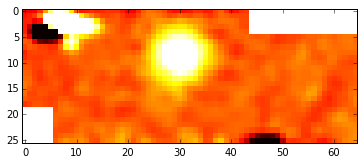

In [14]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(fcube[3358, :, 45:110], cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

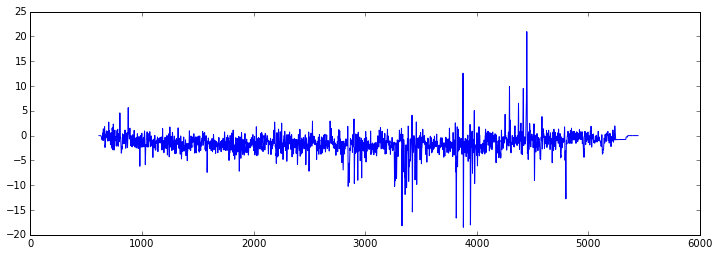

In [15]:
plt.gcf().set_size_inches(12.,4.)
spectrum = fcube[:, 8, 30]
plt.plot(spectrum)

<h2> Multiple 2D/1D passes</h2>

One can use astropy or scipy to do 3-D convolutions as a series of 2-D and 1-D convolutions. Interestingly, even with the explicit looping at the Python script level, this technique is still much faster in astropy than the single-pass 3-D.

Here is the example with astropy:

In [16]:
inter = np.zeros(shape=datacube.shape)
result = np.zeros(shape=datacube.shape)

k1 = Gaussian1DKernel(1.)
k2 = Gaussian2DKernel(1.)

start_time = time.time()

for i in range(datacube.shape[0]):
    inter[i,:,:] = convolve(datacube[i,:,:], k2)
for i in range(datacube.shape[1]):
    for j in range(datacube.shape[2]):
        result[:,i,j] = convolve(inter[:,i,j], k1)

end_time = time.time()
print(str(end_time - start_time) + " seconds.")

11.8531432152 seconds.


The same example above but with scipy's gaussian_filter and gaussian_filter1d results in a factor ~2 slower than with the full fledged 3-D gaussian_filter.

<h3> Result </h3>

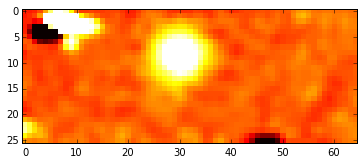

In [17]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(result[3358, :, 45:110], cmap=cm.hot, vmin=-10, vmax=10, interpolation='nearest')

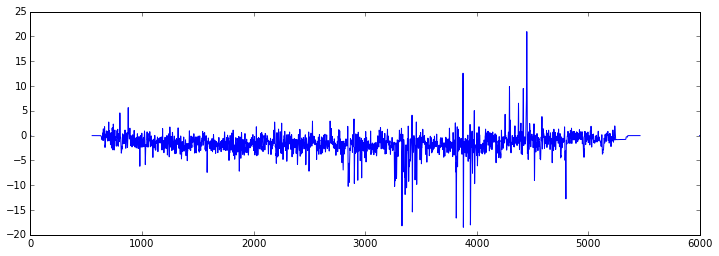

In [18]:
plt.gcf().set_size_inches(12.,4.)
spectrum = result[:, 8, 30]
plt.plot(spectrum)